In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import animate

# Parameter setting

Plot formatting

In [4]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Names

In [60]:
name_catalog = '\emph{{Gaia}}-unWISE Quasar Catalog'
abbrv_catalog = 'QUaia'

name_gpurer = "\emph{{Gaia}} DR3 Quasars 'Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 'Purer'"

name_gall = "\emph{{Gaia}} DR3 Quasar Candidates"
abbrv_gall = "\emph{{Gaia}} DR3 Quasar Candidates"

name_sqall = "eBOSS Quasars"
abbrv_sqall = "eBOSS Quasars"

Plotting variables

In [22]:
cmap_anim = utils.shiftedColorMap(matplotlib.cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0)
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)
cmap_hist = utils.shiftedColorMap(matplotlib.cm.inferno_r, start=0.1, midpoint=0.55, stop=1.0)

color_gaia = 'purple'

Functions

In [23]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [44]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [45]:
G_hi = 20.5
G_lo = 20.0

In [46]:
rng = np.random.default_rng(seed=42)

# Perturbed magnitude catalogs

In [5]:
G_max = 20.5
tag_qspec = ''

In [6]:
tag_cat = ''
fn_gcat = f'../data/QUaia_G{G_max}{tag_qspec}{tag_cat}.fits'
tab_gcat = utils.load_table(fn_gcat)
print(len(tab_gcat))

1295502


In [7]:
tag_cat = '_mags0.05'
fn_gcatp = f'../data/QUaia_G{G_max}{tag_qspec}{tag_cat}.fits'
tab_gcatp = utils.load_table(fn_gcatp)
print(len(tab_gcatp))

1233390


In [8]:
tag_cat = '_mags-0.05'
fn_gcatm = f'../data/QUaia_G{G_max}{tag_qspec}{tag_cat}.fits'
tab_gcatm = utils.load_table(fn_gcatm)
print(len(tab_gcatm))

1353229


(13.0, 21.0)

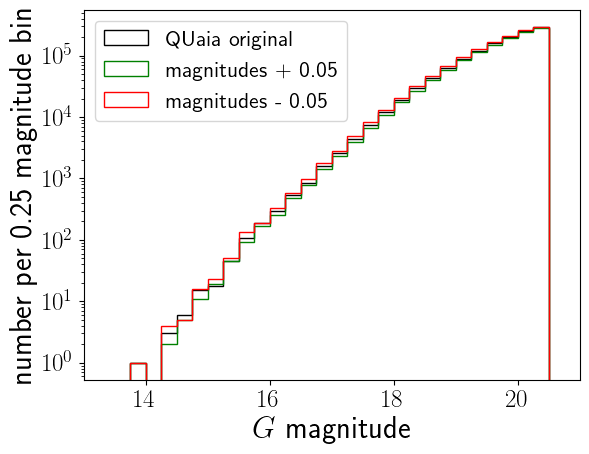

In [15]:
xlim = 13, 21
bin_width = 0.25
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)

plt.hist(tab_gcat['phot_g_mean_mag'], label='QUaia original', 
         bins=G_bins, histtype='step', color='black')
plt.hist(tab_gcatp['phot_g_mean_mag'], label='magnitudes + 0.05',
        bins=G_bins, histtype='step', color='green')
plt.hist(tab_gcatm['phot_g_mean_mag'], label='magnitudes - 0.05',
        bins=G_bins, histtype='step', color='red')

plt.yscale('log')
plt.xlabel(r'$G$ magnitude')
plt.ylabel(f'number per {bin_width} magnitude bin')
plt.legend(fontsize=16)

plt.xlim(xlim)

# Selection function with mean

In [25]:
tag_qspec = '_qeboss'

In [50]:
fn_gcatlo = f'../data/catalog_G{G_lo}{tag_qspec}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

748763


In [56]:
map_gcatlo = get_ndens_map(tab_gcatlo['ra'], tab_gcatlo['dec'])

In [35]:
fn_sel = f"../data/maps/selection_function_NSIDE{NSIDE}_G{G_lo}{tag_qspec}.fits"
map_sel = hp.read_map(fn_sel)

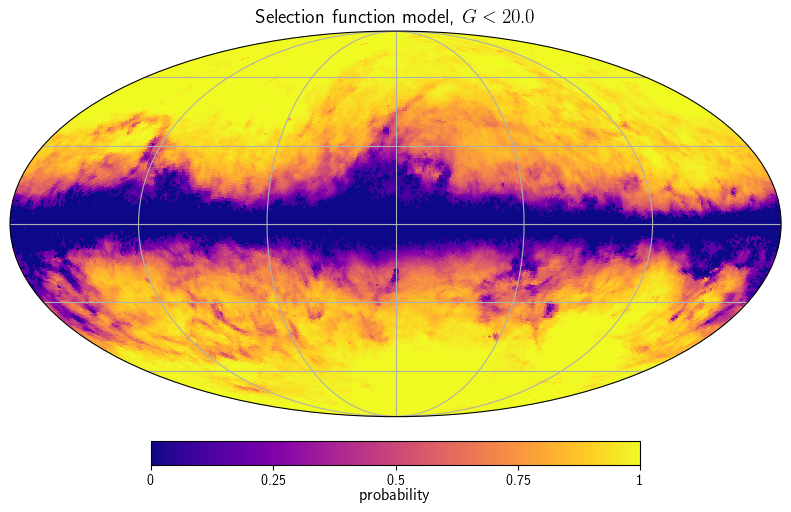

In [36]:
projview(map_sel, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

In [37]:
fn_sel_setmean = f"../data/maps/selection_function_NSIDE{NSIDE}_G{G_lo}{tag_qspec}_setmean.fits"
map_sel_setmean = hp.read_map(fn_sel_setmean)

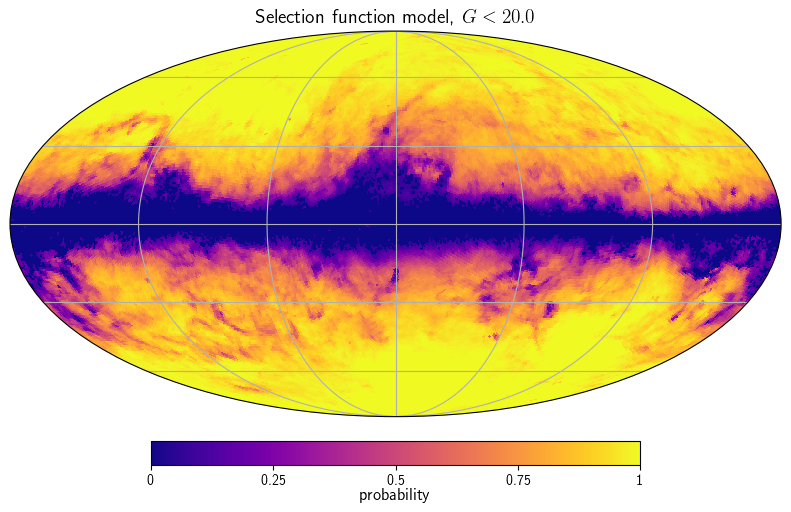

In [38]:
projview(map_sel_setmean, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

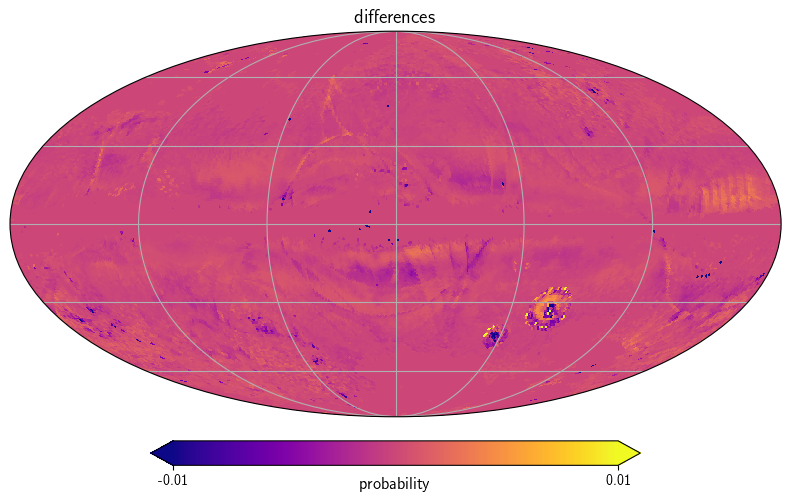

In [41]:
map_diff = map_sel - map_sel_setmean
projview(map_diff, title=rf"differences",
         unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         #min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         min=-0.01, max=0.01
         ) 

#### Random orig

In [52]:
fn_rand_Glo = f'../data/randoms/random_G{G_lo}{tag_qspec}_10x.fits'
tab_rand_Glo = Table.read(fn_rand_Glo)
print(f"Number of random sources: {len(tab_rand_Glo)}")

Number of random sources: 7516086


In [53]:
map_rand_Glo = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'])

In [57]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
print(norm_factor)
map_residuals_Glo = norm_factor*map_rand_Glo/map_gcatlo - 1

0.09962139869075473


In [58]:
print(np.mean(norm_factor*map_rand_Glo), np.mean(map_gcatlo))
print('RMSE:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo))
print('RMSE frac:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo, fractional=True))

21.039424536189973 21.03942453618997
RMSE: 5.426932757885079
RMSE frac: 0.5153129980171205


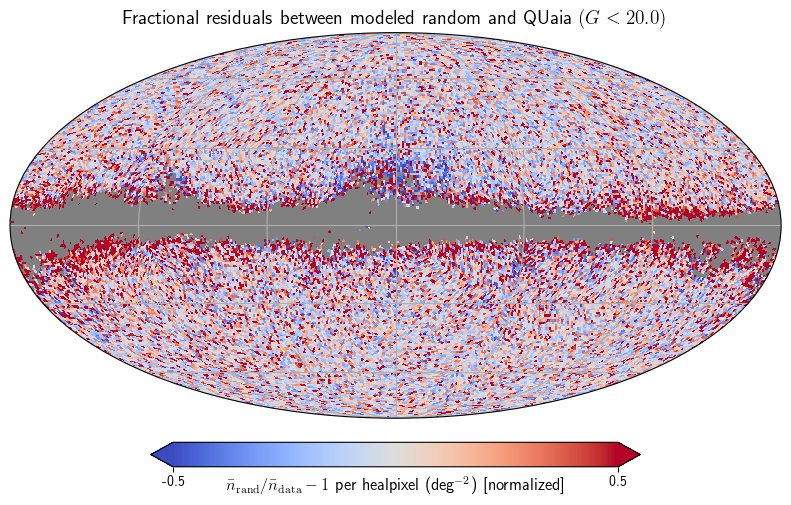

In [62]:
projview(map_residuals_Glo, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", 
          cmap='coolwarm', coord=['C', 'G'], 
            min=-0.5, max=0.5, 
            graticule=True
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

#### Random setmean

In [63]:
fn_rand_Glo = f'../data/randoms/random_G{G_lo}{tag_qspec}_setmean_10x.fits'
tab_rand_Glo = Table.read(fn_rand_Glo)
print(f"Number of random sources: {len(tab_rand_Glo)}")

Number of random sources: 7515861


In [64]:
map_rand_Glo = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'])

In [65]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
print(norm_factor)
map_residuals_Glo = norm_factor*map_rand_Glo/map_gcatlo - 1

0.09962438102567357


In [66]:
print(np.mean(norm_factor*map_rand_Glo), np.mean(map_gcatlo))
print('RMSE:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo))
print('RMSE frac:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo, fractional=True))

21.039424536189973 21.03942453618997
RMSE: 5.426552140894838
RMSE frac: 0.5153312376330136


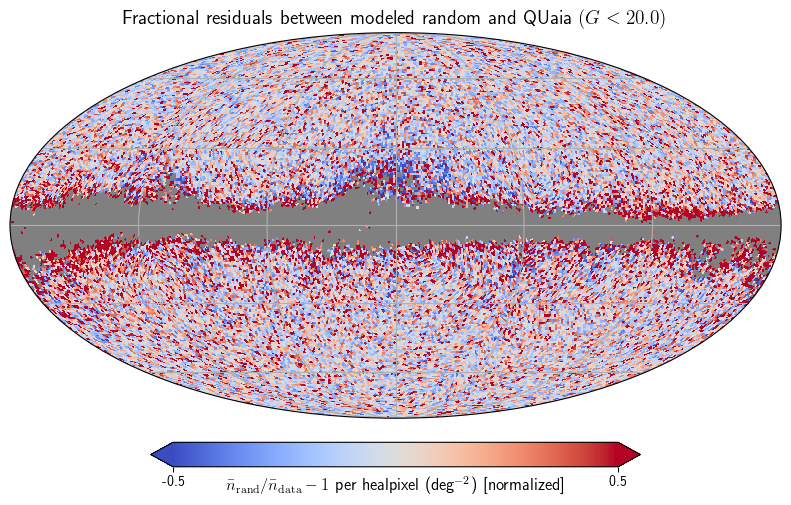

In [67]:
projview(map_residuals_Glo, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", 
          cmap='coolwarm', coord=['C', 'G'], 
            min=-0.5, max=0.5, 
            graticule=True
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

RMSE barely different! looks like doesnt make much of a diff. but could set the mean just for robustness.